<a href="https://colab.research.google.com/github/NID123-CH/Pytorch-and-Image-Processing/blob/main/Vison_Transormer_(VIT)ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [23]:
import tensorflow_datasets as tfds

In [24]:
(dataset_train_original, dataset_validation_original, dataset_test_original), info =tfds.load(
    "cats_vs_dogs",
    split=["train[:70%]", "train[70%:85%]", "train[85%:]"],
    with_info =True,
    as_supervised=True,
)

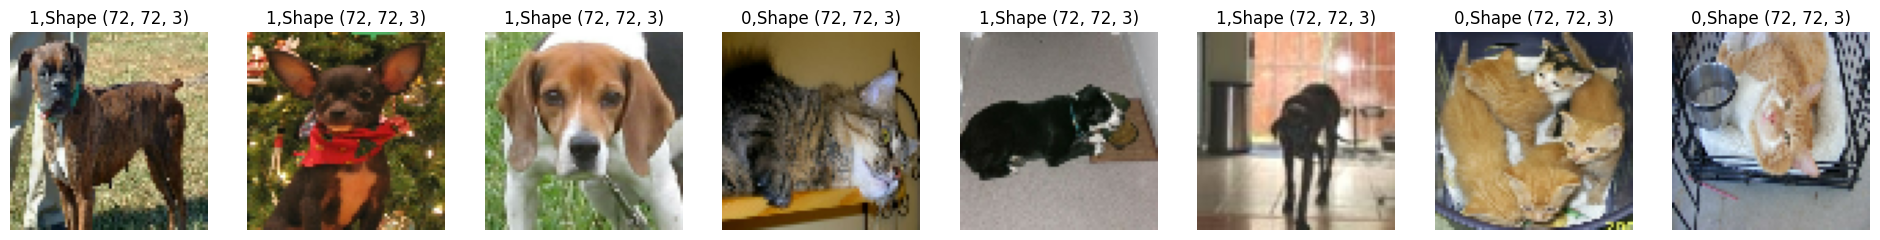

In [25]:
def encode(image, labels):
  image= tf.image.convert_image_dtype(image, tf.float32)
  image =tf.image.resize(image,(72,72))
  return image, labels

dataset =dataset_train_original.map(encode)

index=1
num_samples=8
plt.figure(figsize=(24,4))
for image, label in dataset.take(num_samples):
  plt.subplot(1, num_samples, index)
  plt.imshow(image)
  plt.title(f"{label},Shape {image.shape}")
  plt.axis("off")
  index +=1



In [26]:
batch_size =128
dataset = dataset_train_original.map(encode).cache().shuffle(16000).batch(batch_size)
dataset_validation = dataset_validation_original.map(encode).cache().batch(batch_size)
dataset_test = dataset_test_original.map(encode).cache().batch(batch_size)

In [ ]:
history_list = {}
epochs = 50

def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()


def compare_histories():
    for training_name, history in history_list.items():
        plt.plot(history["val_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()

**VIT**

In [27]:
class Patch(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
    def __call__(self, images):      #Create patches and flatten images :(batch_size,height, width,channel)Returns: (batch_size, xyz, channels)#
         batch_size = tf.shape(images)[0]
         patches=tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
         channels = patches.shape[-1]

        #patches shape =(batch_size, patch_size, channels)
         patches = tf.reshape(patches, [batch_size, -1, channels])
         return patches




<Patch name=patch_3, built=False>

In [28]:
# prompt: write code to generate patches class Patch(layers.Layer):
#     def __init__(self, patch_size):
#         super().__init__()
#         self.patch_size = patch_size
#     def __call__(self, images):      #Create patches and flatten images :(batch_size,height, width,channel)Returns: (batch_size, xyz, channels)#
#          batch_size = tf.shape(images)[0]
#          patches=tf.image.extract_patches(
#             images=images,
#             sizes=[1, self.patch_size, self.patch_size, 1],
#             strides=[1, self.patch_size, self.patch_size, 1],
#             rates=[1, 1, 1, 1],
#             padding="VALID",
#         )
#          channels = patches.shape[-1]
#         #patches shape =(batch_size, patch_size, channels)
#          patches = tf.reshape(patches, [batch_size, -1, channels])
#          return patches
# Patch(8)

class Patch(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def __call__(self, images):
        # Create patches and flatten images:
        # (batch_size, height, width, channel)
        # Returns: (batch_size, xyz, channels)
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]

        # patches shape =(batch_size, patch_size, channels)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches



In [51]:
class Patch(layers.Layer):
  def __init__(self, patch_size):
    super().__init__()
    self.patch_size = patch_size

  def call(self, images):
    images = tf.cast(images, tf.float32)
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    print(patches.shape)
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

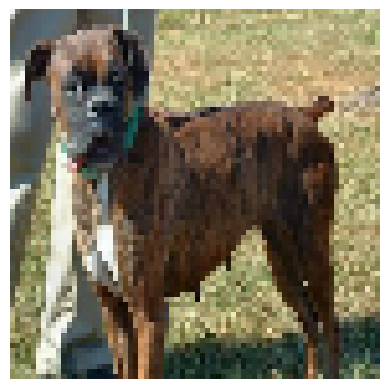

(1, 9, 9, 192)
(1, 81, 192)
(81, 8, 8, 3)


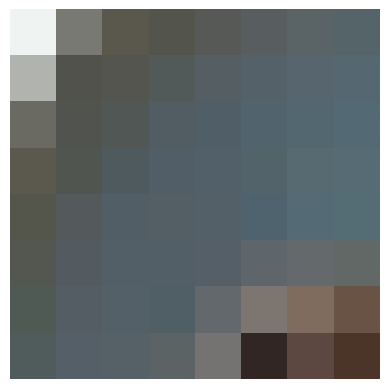

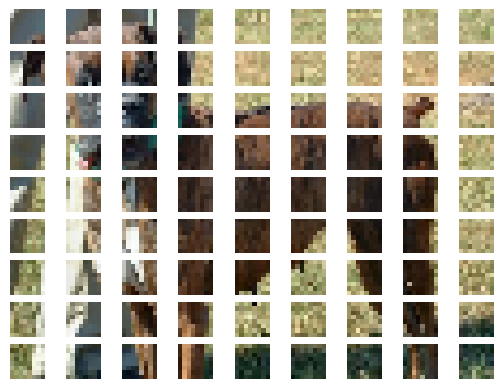

In [52]:
patch_size=8
dataset_to_visualize =dataset_train_original.map(encode).cache().batch(1)
patches_layer =Patch(patch_size)

for images, _ in dataset_to_visualize.take(1):

    plt.imshow(images[0])
    plt.axis("off")
    plt.show()


    patches =patches_layer(images)
    print(patches.shape)

    patches =tf.reshape(patches,(-1,patch_size,patch_size,3))
    print(patches.shape)

    #viz 1 patch
    plt.imshow(patches[0])
    plt.axis("off")
    plt.show()

    #plt.figure(figsize=(24,4)
    for i in range(81):
      ax=plt.subplot(9,9,i+1)
      ax.imshow(patches[i])
      plt.axis("off")
    plt.show()
    plt.close()

In [53]:
tf.range(start=0, limit=10, delta=1)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>

In [54]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def __call__(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

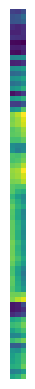

(1, 9, 9, 192)


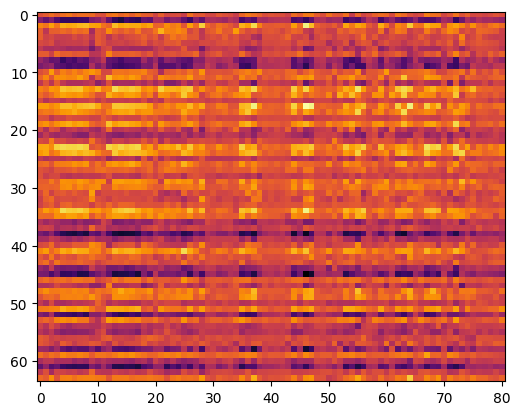

In [55]:
patch_size =8
num_patches =81
embed_dim =64

dataset_to_visualize =dataset_train_original.map(encode).cache().batch(1)

patches_layer =Patch(patch_size)
patch_encoder_layer =PatchEncoder(num_patches,embed_dim)

for images, _ in dataset_to_visualize.take(1):
    plt.imshow(image[0])
    plt.axis("off")
    plt.show()

    patches =patches_layer(images)

    patch_encoding = patch_encoder_layer(patches)


    #plt.imshow(patch_encoding[0].numpy().trans,cmap ="inferno")
    plt.imshow(patch_encoding[0].numpy().T,cmap ="inferno")

In [56]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)

        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),])

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def __call__(self, inputs):
      normalized_inputs = self.layernorm_1(inputs)
      attention_output = self.attention(normalized_inputs, normalized_inputs, normalized_inputs )

      sum = inputs + attention_output

      normalized_sum = self.layernorm_2(sum)

      projection_output = self.dense_proj(normalized_sum)
      result = sum + projection_output
      return result






In [57]:
patch_size  =8
num_patches =81
embed_dim   =16
num_heads   =4
num_encoders = 2

model=models.Sequential()
model.add(layers.Input(shape=(72,72,3)))
model.add(Patch(patch_size))
model.add(PatchEncoder(num_patches,embed_dim))

for i in range(num_encoders):
  model.add(TransformerEncoder(embed_dim=embed_dim,dense_dim=embed_dim*2,num_heads=num_heads))

model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()


(None, 9, 9, 192)
(None, 9, 9, 192)
(None, 9, 9, 192)
(None, 9, 9, 192)
(None, 9, 9, 192)
(None, 9, 9, 192)
(None, 9, 9, 192)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ patch_19 (Patch)                     │ (None, None, 192)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_encoder_5 (PatchEncoder)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ ?                           │     0 (unbuilt) │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_1                │ ?                           │     0 (unbuilt) │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,281 (59.69 KB)

 Trainable params: 15,281 (59.69 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Create the training and validation datasets using the 'encode' function (you'll need to define it)
dataset_train = dataset_train_original.map(encode).cache().batch(1)
dataset_valid = dataset_validation_original.map(encode).cache().batch(1)

model.compile(optimizer ="adam", loss="binary_crossentropy",metrics=["accuracy"])
history = model.fit(
    dataset_train,
    validation_data=dataset_valid,
    epochs=10,
)

Epoch 1/10
(None, 9, 9, 192)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['embeddings'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


(None, 9, 9, 192)
16279/16283 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5207 - loss: 0.7334(None, 9, 9, 192)
16283/16283 ━━━━━━━━━━━━━━━━━━━━ 170s 10ms/step - accuracy: 0.5207 - loss: 0.7334 - val_accuracy: 0.5725 - val_loss: 0.6758
Epoch 2/10
16283/16283 ━━━━━━━━━━━━━━━━━━━━ 118s 7ms/step - accuracy: 0.5758 - loss: 0.6779 - val_accuracy: 0.6054 - val_loss: 0.6504
Epoch 3/10
16283/16283 ━━━━━━━━━━━━━━━━━━━━ 121s 7ms/step - accuracy: 0.6002 - loss: 0.6601 - val_accuracy: 0.6226 - val_loss: 0.6344
Epoch 4/10
16283/16283 ━━━━━━━━━━━━━━━━━━━━ 121s 7ms/step - accuracy: 0.6211 - loss: 0.6430 - val_accuracy: 0.6438 - val_loss: 0.6222
Epoch 5/10
16283/16283 ━━━━━━━━━━━━━━━━━━━━ 119s 7ms/step - accuracy: 0.6360 - loss: 0.6339 - val_accuracy: 0.6530 - val_loss: 0.6226
Epoch 6/10
16283/16283 ━━━━━━━━━━━━━━━━━━━━ 120s 7ms/step - accuracy: 0.6502 - loss: 0.6240 - val_accuracy: 0.6782 - val_loss: 0.5991
Epoch 7/10
16283/16283 ━━━━━━━━━━━━━━━━━━━━ 119s 7ms/step - accuracy: 0.6614 - loss: 0.6126 